## Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob 
import random
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Conv1D, GlobalMaxPooling1D, MaxPooling1D, GRU
from tcn import TCN, tcn_full_summary
import time

# Task 1 - Data Analysis

## Understanding data

In [2]:
df = pd.read_csv(r"E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\data/01238.csv", encoding='unicode_escape', sep="\s|:", engine='python')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time_/min             2000 non-null   object 
 1   temp/°C               2000 non-null   object 
 2   DSCalpha              2000 non-null   object 
 3   impedance1.78kHz/Ohm  2000 non-null   object 
 4   Tg/C                  2000 non-null   object 
 5   Derivative            2000 non-null   object 
 6   Y1                    0 non-null      float64
dtypes: float64(1), object(6)
memory usage: 109.5+ KB


In [4]:
# Removing unnecessary columns
df = df.iloc[:, :4]

In [5]:
df = df.applymap(lambda x: float(x.replace(',','.').replace('E','e')))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time_/min             2000 non-null   float64
 1   temp/°C               2000 non-null   float64
 2   DSCalpha              2000 non-null   float64
 3   impedance1.78kHz/Ohm  2000 non-null   float64
dtypes: float64(4)
memory usage: 62.6 KB


In [6]:
df.describe()

,time_/min,temp/°C,DSCalpha,impedance1.78kHz/Ohm
count,2000.000000,2000.000000,2000.000000,2.000000e+03
mean,192.896552,154.852872,0.685387,4.958039e+06
std,111.452432,41.196931,0.418556,1.642289e+06
min,0.000000,28.553426,0.000000,7.602916e+05
25%,96.448750,132.830836,0.163984,5.349485e+06
50%,192.896500,181.000000,0.971767,5.744598e+06
75%,289.345250,181.000000,0.998103,5.802682e+06
max,385.793000,181.000000,0.999413,6.067556e+06


## Writing functions for finding critical points, plotting impedance curve, finding Xcp23 and Delta_T

In [7]:
def critical_points(df):
    
    # CP2 is where impedance value is minimum
    cp2 = df[df['impedance1.78kHz/Ohm'] == df['impedance1.78kHz/Ohm'].min()].index.tolist()[0]
    
    # CP4 is where DSCalpha value becomes more than 0.95 
    cp4 = df[df['DSCalpha'] >= 0.95].index.tolist()[0]
    
    # To find point of inflection we find second derivative
    # As the inflection point is between CP2 and CP4, we calculate derivatives only between these points
    df[['first_der', 'second_der', 'curve_dir_change']] = np.nan
    dy = np.diff(df['impedance1.78kHz/Ohm'].iloc[cp2:cp4+1])
    dx = np.diff(df['time_/min'].iloc[cp2:cp4+1])
    df['first_der'].iloc[cp2+1:cp4+1] = dy/dx
    d2y = np.diff(df['first_der'].iloc[cp2+1:cp4+1])
    d2x = 0.5*(df['time_/min'].iloc[cp2:cp4]+df['time_/min'].iloc[cp2+1:cp4+1]).dropna()
    df['second_der'].iloc[cp2+2:cp4+1] = d2y/d2x
    
    # Point of inflection is where second derivative changes sign, 
    # hence multiplying each second derivative value with previous to find where multiplication is negative
    df['curve_dir_change'].iloc[cp2+3:cp4+1] = np.multiply(np.array(df['second_der'].iloc[cp2+2:cp4]), np.array(df['second_der'].iloc[cp2+3:cp4+1]))
    cp3 = df[df['curve_dir_change']<=0].index.tolist()[0]
    
    return cp2, cp3, cp4

In [8]:
def find_delta_t(df, cp2, cp4):
    # Difference between time at CP4 and CP2
    delta_t = df['time_/min'].iloc[cp4] - df['time_/min'].iloc[cp2]
    return delta_t

In [9]:
def find_train_data(df, cp2, cp3):
    xcp23 = df.iloc[cp2:cp3+1, :4]
    return xcp23

In [10]:
def impedance_curve(df, filename, cp2, cp3, cp4):
    plt.scatter(df['time_/min'], df['impedance1.78kHz/Ohm'], s = 5)

    # Highlight a specific data point
    plt.scatter(df['time_/min'].iloc[cp2], df['impedance1.78kHz/Ohm'].iloc[cp2], c='brown', marker='o')
    plt.annotate('CP2', (df['time_/min'].iloc[cp2], df['impedance1.78kHz/Ohm'].iloc[cp2]), xytext=(-60, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'), c='brown')

    plt.scatter(df['time_/min'].iloc[cp3], df['impedance1.78kHz/Ohm'].iloc[cp3], c='green', marker='o')
    plt.annotate('CP3', (df['time_/min'].iloc[cp3], df['impedance1.78kHz/Ohm'].iloc[cp3]), xytext=(50, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'), c='green')

    plt.scatter(df['time_/min'].iloc[cp4], df['impedance1.78kHz/Ohm'].iloc[cp4], c='orange', marker='o')
    plt.annotate('CP4', (df['time_/min'].iloc[cp4], df['impedance1.78kHz/Ohm'].iloc[cp4]), xytext=(50, -30), textcoords='offset points', arrowprops=dict(arrowstyle='->'), c='orange')

    plt.xlabel("Time (min)", fontsize=13, labelpad=10)
    plt.xticks(fontsize=10)
    plt.ylabel("Impedance", fontsize=13, labelpad=10)
    plt.yticks(fontsize=10)
    plt.title(f"Impedance Curve - {filename}", fontsize=16, pad=15)
    plt.show()

## Trial of all the functions

In [11]:
cp2, cp3, cp4 = critical_points(df)
print(df['time_/min'].iloc[cp2],df['time_/min'].iloc[cp3],df['time_/min'].iloc[cp4])

75.074 95.918 176.589


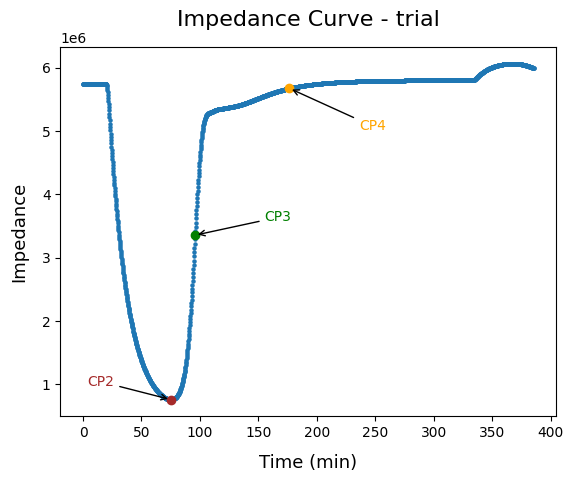

In [12]:
impedance_curve(df, 'trial', cp2, cp3, cp4)

In [13]:
delta_t = find_delta_t(df, cp2, cp4)
delta_t

101.515

In [14]:
xcp23 = find_train_data(df, cp2, cp3)
xcp23.shape

(109, 4)

## Understanding Xcp23 data

In [15]:
xcp23.describe()

,time_/min,temp/°C,DSCalpha,impedance1.78kHz/Ohm
count,109.000000,109.000000,109.000000,1.090000e+02
mean,85.496000,167.470905,0.062544,1.401059e+06
std,6.100652,8.718433,0.040088,7.442382e+05
min,75.074000,152.439853,0.015768,7.602916e+05
25%,80.285000,159.995494,0.028334,8.113890e+05
50%,85.496000,167.551247,0.050820,1.061948e+06
75%,90.707000,175.106903,0.090239,1.803854e+06
max,95.918000,180.830577,0.155876,3.357472e+06


##### As there is huge difference between numerical values in all the columns, standardization will be required before training

In [16]:
xcp23 = xcp23.apply(stats.zscore)
xcp23

,time_/min,temp/°C,DSCalpha,impedance1.78kHz/Ohm
389,-1.716233,-1.732018,-1.172237,-0.864947
390,-1.684451,-1.699776,-1.163579,-0.864895
391,-1.652668,-1.667531,-1.154729,-0.864697
392,-1.620886,-1.635282,-1.145683,-0.864350
393,-1.589104,-1.603031,-1.136438,-0.863847
...,...,...,...,...
493,1.589104,1.516700,2.051822,2.278586
494,1.620886,1.524115,2.122604,2.369043
495,1.652668,1.530229,2.194075,2.459682
496,1.684451,1.535270,2.266202,2.550348


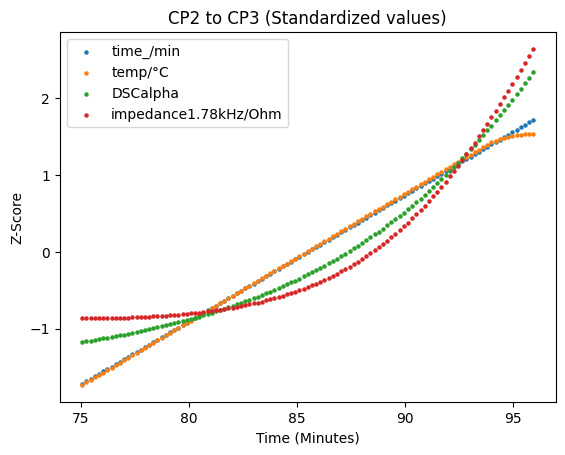

In [17]:
columns = list(df.columns)
plt.scatter(df['time_/min'].iloc[cp2:cp3+1], xcp23['time_/min'], label=columns[0], s=5)
plt.scatter(df['time_/min'].iloc[cp2:cp3+1], xcp23['temp/°C'], label=columns[1], s=5)
plt.scatter(df['time_/min'].iloc[cp2:cp3+1], xcp23['DSCalpha'], label=columns[2], s=5)
plt.scatter(df['time_/min'].iloc[cp2:cp3+1], xcp23['impedance1.78kHz/Ohm'], label=columns[3], s=5)
plt.title('CP2 to CP3 (Standardized values)')
plt.ylabel('Z-Score')
plt.xlabel('Time (Minutes)')
plt.legend(loc='upper left')
plt.show()

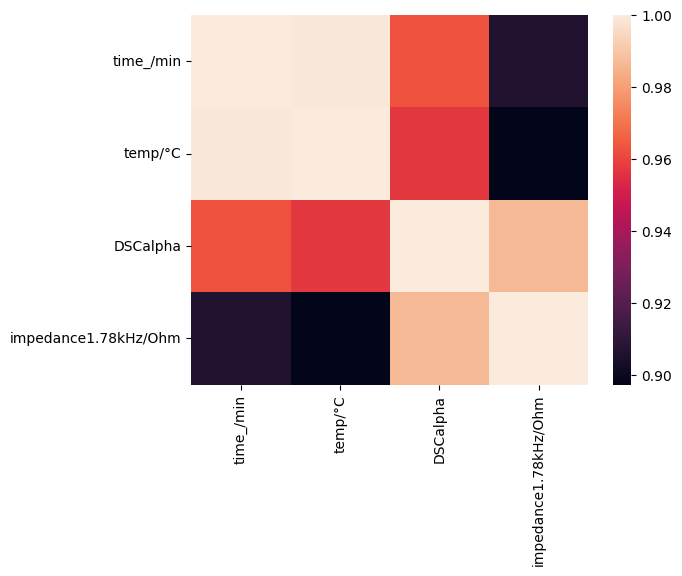

In [18]:
sns.heatmap(xcp23.corr())
plt.show()

##### Removing temperature values as it's distribution between CP2 and CP3 should not affect the values of delta_t as it is almost constant for all the measurements

In [19]:
xcp23 = xcp23.iloc[:, 1:4]

##### There is clear correlation between all the variables so we can do dimensionality reduction using PCA

In [20]:
pca = PCA(n_components = 3)
pca.fit(xcp23)
(pca.explained_variance_ratio_*100)

array([9.64786746e+01, 3.51596341e+00, 5.36193780e-03])

##### Looks like only first two PCA dimensions will be enough to represent complete data

### To see if only 2 dimension after PCA can represent data, we can test PCA randomly on 10 different cycles

In [21]:
path = r"E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\data"
files = glob.glob(path + "/*.csv")
files = random.sample(files, 10)

# loop over the list of csv files 
for i, f in enumerate(files): 
    
    # reading the csv file 
    df = pd.read_csv(f, encoding='unicode_escape', sep="\s|:", engine='python') 
    
    # Keeping only required columns and converting data to required format
    df = df.iloc[:, :4]
    df = df.applymap(lambda x: float(x.replace(',','.').replace('E','e')))
    
    # Finding critical points and creating dataset
    cp2, cp3, cp4 = critical_points(df)
    xcp23 = find_train_data(df, cp2, cp3)

    # Standardizing all columns
    xcp23 = xcp23.apply(stats.zscore)
    
    # PCA analysis
    cycle = f.split('\\')[-1].split('.')[0]
    print(f"{i+1}) For cycle {cycle}")
    pca = PCA(n_components = 3)
    pca.fit(xcp23)
    print(f"{pca.explained_variance_ratio_*100}\n")

1) For cycle 00591
[9.63037482e+01 3.67838720e+00 1.44161464e-02]

2) For cycle 01360
[9.40510025e+01 5.91310406e+00 3.51478131e-02]

3) For cycle 02015
[9.66820354e+01 3.31508907e+00 2.87550293e-03]

4) For cycle 01105
[9.48454846e+01 5.11193195e+00 4.12160642e-02]

5) For cycle 00192
[9.55866169e+01 4.37146332e+00 3.97478237e-02]

6) For cycle 02688
[9.65594495e+01 3.43727091e+00 3.27960678e-03]

7) For cycle 00411
[9.55552812e+01 4.40278502e+00 3.96949150e-02]

8) For cycle 03568
[9.14791199e+01 8.49200357e+00 2.13968914e-02]

9) For cycle 00167
[9.61485786e+01 3.82407081e+00 2.43476929e-02]

10) For cycle 02600
[9.59761436e+01 4.00540746e+00 1.40330919e-02]



##### For all the cycles selected randomly first two dimensions represent the data almost completely, so we keep 2 dimensions after PCA

In [22]:
pca = PCA(n_components = 2)
pca.fit(xcp23)
data_pca = pca.transform(xcp23)
data_pca = pd.DataFrame(data_pca, columns=["pca1", "pca2"])
data_pca.describe()

,pca1,pca2
count,9.400000e+01,94.000000
mean,8.503836e-17,0.000000
std,1.969854e+00,0.402417
min,-2.731921e+00,-0.461748
25%,-1.679936e+00,-0.366732
50%,-3.748180e-01,-0.097655
75%,1.481870e+00,0.303752
max,4.093590e+00,0.967009


##### The time at which CP2 and CP3 is reached might have some effect on the time to reach CP4. Hence, in order to not loose the numerical value of time at CP2/CP3, we can scale these values around the mean time between CP2 and CP3

In [23]:
mean_time_cp2_cp3 = df['time_/min'].iloc[cp2:cp3+1].mean()
data_pca = data_pca.apply(lambda x: mean_time_cp2_cp3 * x)
data_pca

,pca1,pca2
0,-192.840813,52.640678
1,-189.870152,50.320154
2,-186.867753,48.000453
3,-183.865963,45.707696
4,-180.831349,43.416793
...,...,...
89,256.311183,46.362104
90,264.491906,51.761869
91,272.632641,57.203892
92,280.818456,62.728294


## Writing function for complete data transformation including standardization, PCA and scaling

In [24]:
def data_transformation(df, mean_time_cp2_cp3):
    
    # Standardising data
    df = df.apply(stats.zscore)
    
    # Applying PCA transform to reduce dimensionality
    pca = PCA(n_components = 2)
    pca.fit(df)
    data_pca = pca.transform(df)
    data_pca = pd.DataFrame(data_pca, columns=["pca1", "pca2"])

    # Scaling data around mean time between CP2 and CP3
    data_pca = data_pca.apply(lambda x: mean_time_cp2_cp3 * x)
    xcp23 = np.array(data_pca)
    
    return xcp23

## Testing Function

In [25]:
data_transformation(xcp23, mean_time_cp2_cp3)

array([[-1.92840813e+02,  5.26406777e+01],
       [-1.89870152e+02,  5.03201541e+01],
       [-1.86867753e+02,  4.80004529e+01],
       [-1.83865963e+02,  4.57076961e+01],
       [-1.80831349e+02,  4.34167930e+01],
       [-1.77796553e+02,  4.11536104e+01],
       [-1.74728357e+02,  3.88941360e+01],
       [-1.71658440e+02,  3.66623474e+01],
       [-1.68553862e+02,  3.44355227e+01],
       [-1.65446644e+02,  3.22373336e+01],
       [-1.62303415e+02,  3.00454435e+01],
       [-1.59156541e+02,  2.78832250e+01],
       [-1.55972175e+02,  2.57287829e+01],
       [-1.52783079e+02,  2.36051300e+01],
       [-1.49554898e+02,  2.14908460e+01],
       [-1.46320793e+02,  1.94085965e+01],
       [-1.43045878e+02,  1.73374549e+01],
       [-1.39763758e+02,  1.52996871e+01],
       [-1.36438958e+02,  1.32749307e+01],
       [-1.33105549e+02,  1.12850332e+01],
       [-1.29727456e+02,  9.31020059e+00],
       [-1.26339236e+02,  7.37184482e+00],
       [-1.22904153e+02,  5.45081310e+00],
       [-1.

## Plotting imepedance curve for 10 random cycles

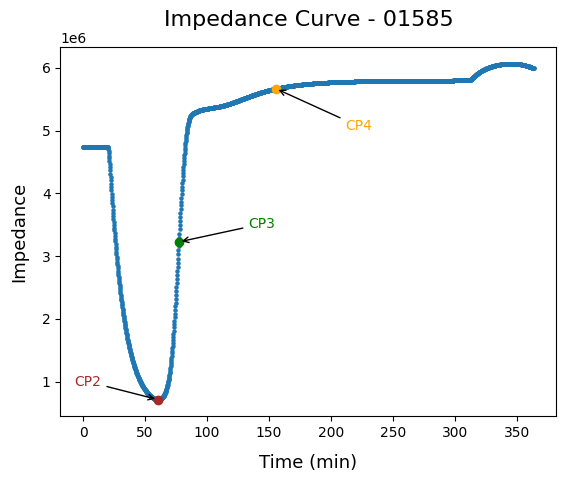

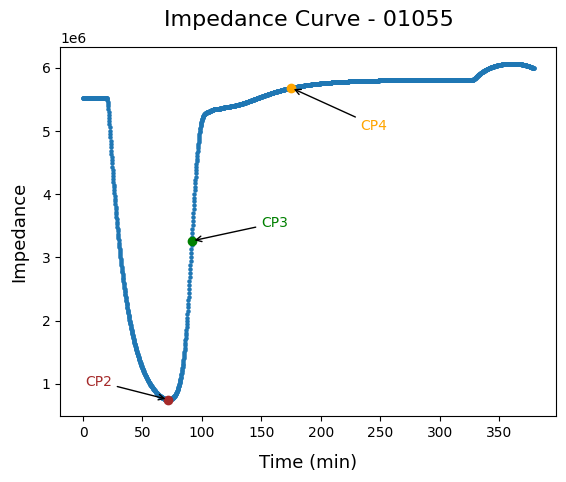

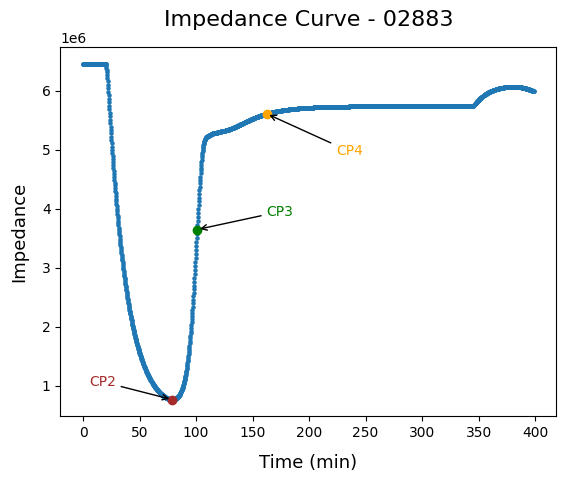

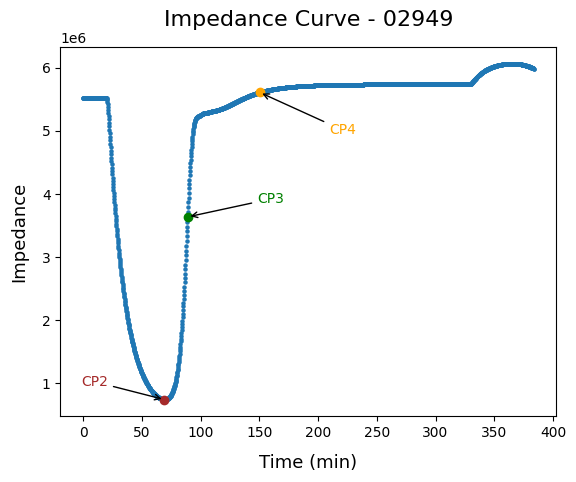

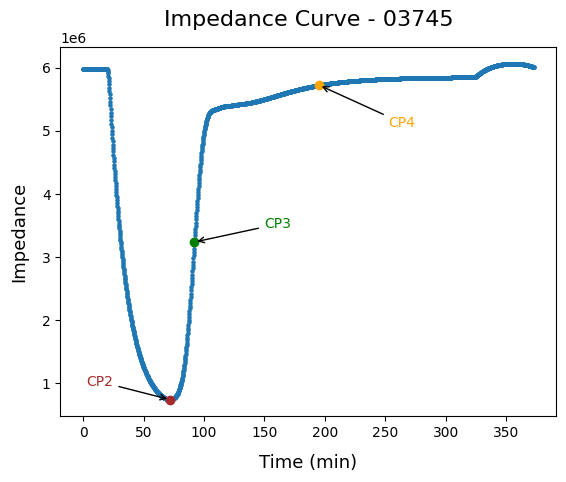

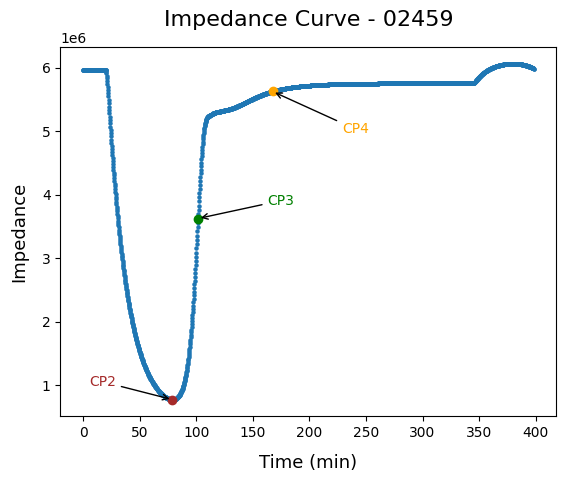

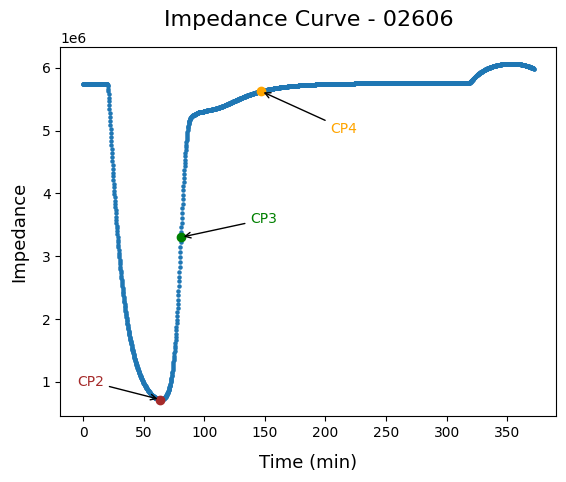

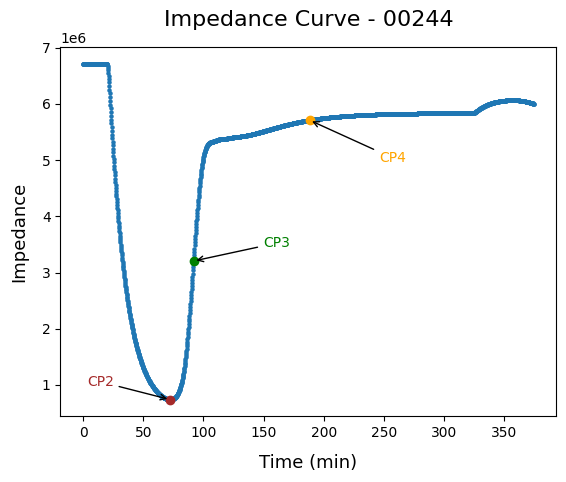

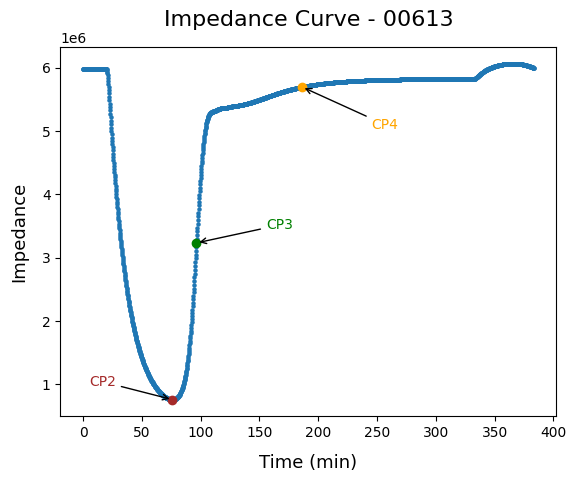

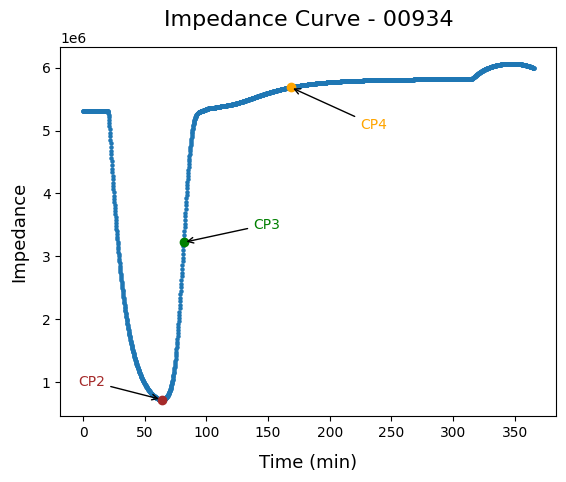

In [26]:
# Add path to the folder that contains data here
path = r"E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\data"
files = glob.glob(path + "/*.csv")
files = random.sample(files, 10)

# loop over the list of csv files 
for f in files: 
    
    # reading the csv file 
    df = pd.read_csv(f, encoding='unicode_escape', sep="\s|:", engine='python') 
    
    # Keeping only required columns and converting data to required format
    df = df.iloc[:, :4]
    df = df.applymap(lambda x: float(x.replace(',','.').replace('E','e')))
    
    # Finding critical points and creating dataset
    cp2, cp3, cp4 = critical_points(df)

    # Plotting impedance curve for this cycle
    cycle = f.split('\\')[-1].split('.')[0]
    impedance_curve(df, cycle, cp2, cp3, cp4)


# Task 2 - ML Modelling

## Creating dataset from all the cycles

In [27]:
path = r"E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\data"
# path = os.getcwd()
files = glob.glob(path + "/*.csv")
dataset = np.empty(2, dtype='object')

start_time = time.time()
# loop over the list of csv files 
for f in files: 
    
    # read the csv file 
    df = pd.read_csv(f, encoding='unicode_escape', sep="\s|:", engine='python') 
    
    # Keeping only required columns and converting data to required format
    df = df.iloc[:, :4]
    df = df.applymap(lambda x: float(x.replace(',','.').replace('E','e')))
    
    # Finding critical points and creating dataset
    cp2, cp3, cp4 = critical_points(df)
    xcp23 = find_train_data(df, cp2, cp3)
    # Removing time for xcp23
    xcp23 = xcp23.iloc[:, 1:4]
    delta_t = find_delta_t(df, cp2, cp4)

    mean_time_cp2_cp3 = df['time_/min'].iloc[cp2:cp3+1].mean()
    xcp23 = data_transformation(xcp23, mean_time_cp2_cp3)

    #Converting xcp23 into numpy array as it will easier for training later
    xcp23 = np.array(xcp23)
    temp_data  = [xcp23, delta_t]
    temp_data = np.array(temp_data, dtype = 'object')

    # Stacking data for this cycle in the dataset
    dataset = np.vstack((dataset, temp_data))

end_time = time.time()
print(f"\nTotal time taken for data preparation = {end_time-start_time} seconds")
dataset = dataset[1:]
dataset.shape


Total time taken for data preparation = 100.98171257972717 seconds


(3926, 2)

## Finding the max and min length of Xcp23 from all the cycles

In [28]:
max_length = 0
min_length = 1000000
for x in dataset[:,0]:
    if x.shape[0] > max_length:
        max_length = x.shape[0]
    if x.shape[0] < min_length:
        min_length = x.shape[0]
print(max_length,min_length)

126 89


## Splitting complete dataset into training, testing and validation datasets

In [29]:
# Randomly shuffeling dataset to remove any sequencial biases
np.random.shuffle(dataset)

# Separating input and target values 
X = dataset[:, 0]
y = dataset[:, 1]


# Pad sequences to the same length as the inputs are of variable lengths
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', dtype='float32')
print(f"Dataset dimensions - {X_padded.shape}")

# Converting targets to numpy array
y = np.asarray(y).astype(np.float32)
print(f"Target dimensions - {y.shape}")

Dataset dimensions - (3926, 126, 2)
Target dimensions - (3926,)


In [30]:
# Finding the dimensions of input data
num_samples = X_padded.shape[0]
sequence_length = X_padded.shape[1]
feature_dim = X_padded.shape[2]

In [31]:
# Splitting into training and testing sets
train_test_split_index = int(0.8 * num_samples)
X_train, X_test = X_padded[:train_test_split_index], X_padded[train_test_split_index:]
y_train, y_test = y[:train_test_split_index], y[train_test_split_index:]
print(f"Test set dimensions - {X_test.shape}, {y_test.shape}")

generated_data_dir = r"E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\generated_data"

with open(os.path.join(generated_data_dir, "x_test"), 'wb') as f:
    pickle.dump(X_test, f)

with open(os.path.join(generated_data_dir, "y_test"), 'wb') as f:
    pickle.dump(y_test, f)

Test set dimensions - (786, 126, 2), (786,)


In [32]:
# Splitting into training and validation sets
train_val_split_index = int(0.8 * X_train.shape[0])
X_train, X_val = X_train[:train_val_split_index], X_train[train_val_split_index:]
y_train, y_val = y_train[:train_val_split_index], y_train[train_val_split_index:]
print(f"Train set dimensions - {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions - {X_val.shape}, {y_val.shape}")

with open(os.path.join(generated_data_dir, "x_train"), 'wb') as f:
    pickle.dump(X_train, f)

with open(os.path.join(generated_data_dir, "x_val"), 'wb') as f:
    pickle.dump(X_val, f)

with open(os.path.join(generated_data_dir, "y_train"), 'wb') as f:
    pickle.dump(y_train, f)

with open(os.path.join(generated_data_dir, "y_val"), 'wb') as f:
    pickle.dump(y_val, f)

Train set dimensions - (2512, 126, 2), (2512,)
Validation set dimensions - (628, 126, 2), (628,)


## Writing models

#### LSTM model

In [33]:
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=0.0)(inputs)
    lstm_out = LSTM(64)(masked_inputs)  # Single output from LSTM
    outputs = Dense(1)(lstm_out)

    model = Model(inputs, outputs)
    return model

input_shape = (sequence_length, feature_dim)
lstm_model = create_lstm_model(input_shape)

#### GRU Model

In [34]:
def create_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=0.0)(inputs)
    gru_out = GRU(64)(masked_inputs)  # Single output from GRU
    outputs = Dense(1)(gru_out)  # Single output

    model = Model(inputs, outputs)
    return model

gru_model = create_gru_model(input_shape)

#### CNN model

In [35]:
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=0.0)(inputs)
    conv_out = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(masked_inputs)
    pooled_out = GlobalMaxPooling1D()(conv_out)
    outputs = Dense(1)(pooled_out)

    model = Model(inputs, outputs)
    return model

cnn_model = create_cnn_model(input_shape)

#### TCN model

In [36]:
def create_tcn_model(input_shape):
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=0.0)(inputs)
    tcn_out = TCN(nb_filters=64, dilations=[1, 2, 4, 8, 16])(masked_inputs)
    outputs = Dense(1)(tcn_out)

    model = Model(inputs, outputs)
    return model

tcn_model = create_tcn_model(input_shape)

## Training Models

#### LSTM model

In [37]:
# Choose the model to train: lstm_model, cnn_model, or tcn_model
# model = lstm_model  # For LSTM
# model = cnn_model  # For CNN
# model = tcn_model  # For TCN

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking (Masking)           (None, 126, 2)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17217 (67.25 KB)
Trainable params: 17217 (67.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time = time.time()
# Train the model
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose = 1
)
end_time = time.time()
print(f"\nTotal training time for LSTM model = {end_time-start_time} seconds")

Epoch 1/2000
79/79 [==============================] - 9s 67ms/step - loss: 11254.5420 - mae: 104.4355 - val_loss: 10939.5020 - val_mae: 102.9960
Epoch 2/2000
79/79 [==============================] - 4s 50ms/step - loss: 10813.6035 - mae: 102.3103 - val_loss: 10571.2607 - val_mae: 101.1934
Epoch 3/2000
79/79 [==============================] - 4s 48ms/step - loss: 10428.9424 - mae: 100.4165 - val_loss: 10148.1992 - val_mae: 99.0813
Epoch 4/2000
79/79 [==============================] - 4s 47ms/step - loss: 9979.0439 - mae: 98.1430 - val_loss: 9737.7441 - val_mae: 96.9876
Epoch 5/2000
79/79 [==============================] - 4s 45ms/step - loss: 9593.8955 - mae: 96.1630 - val_loss: 9327.2656 - val_mae: 94.8479
Epoch 6/2000
79/79 [==============================] - 4s 46ms/step - loss: 9165.5654 - mae: 93.9058 - val_loss: 8904.2393 - val_mae: 92.5911
Epoch 7/2000
79/79 [==============================] - 4s 48ms/step - loss: 8760.8662 - mae: 91.7294 - val_loss: 8525.7217 - val_mae: 90.5239
Ep

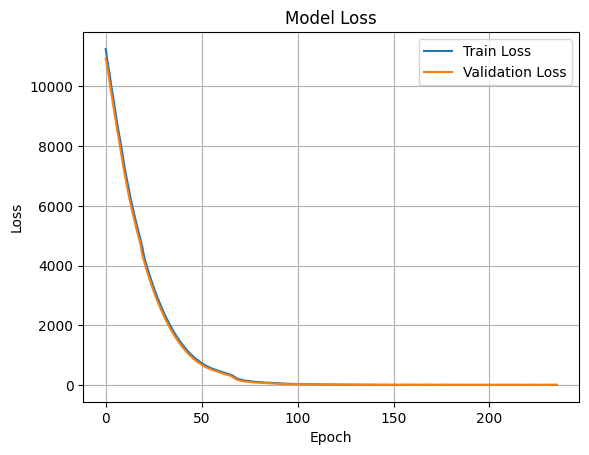

In [39]:
# Plotting training and validation error during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

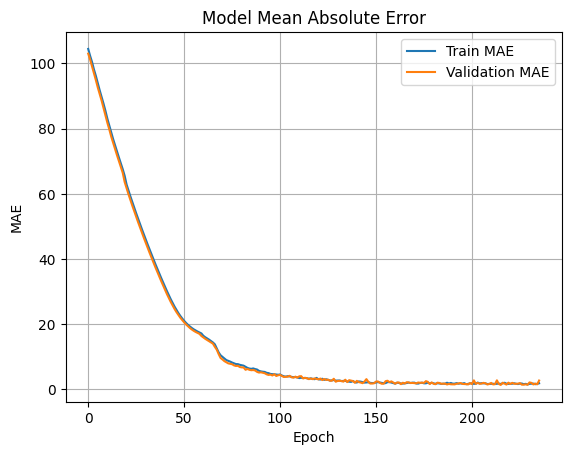

In [40]:
# Plotting training and validation MAE during training
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [41]:
# Save model
lstm_model.save(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\LSTM/lstm_model.h5')
print('Model Saved!')
 
# load model
lstm_model=load_model(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\LSTM/lstm_model.h5')
lstm_model.summary()

C:\Users\lenovo\anaconda3\envs\SensXpertTask\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking (Masking)           (None, 126, 2)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17217 (67.25 KB)
Trainable params: 17217 (67.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### GRU Model

In [42]:
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
gru_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking_1 (Masking)         (None, 126, 2)            0         
                                                                 
 gru (GRU)                   (None, 64)                13056     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time = time.time()
# Train the model
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose = 1
)
end_time = time.time()
print(f"\nTotal training time for GRU model = {end_time-start_time} seconds")

Epoch 1/2000
79/79 [==============================] - 8s 60ms/step - loss: 10122.4160 - mae: 98.8114 - val_loss: 9145.1689 - val_mae: 93.8838
Epoch 2/2000
79/79 [==============================] - 3s 43ms/step - loss: 8739.9854 - mae: 91.5894 - val_loss: 8221.5723 - val_mae: 88.8283
Epoch 3/2000
79/79 [==============================] - 3s 43ms/step - loss: 7858.3687 - mae: 86.6389 - val_loss: 7378.6694 - val_mae: 83.9497
Epoch 4/2000
79/79 [==============================] - 4s 45ms/step - loss: 7053.2686 - mae: 81.8469 - val_loss: 6607.3882 - val_mae: 79.2228
Epoch 5/2000
79/79 [==============================] - 3s 43ms/step - loss: 6317.6050 - mae: 77.2075 - val_loss: 5902.9072 - val_mae: 74.6443
Epoch 6/2000
79/79 [==============================] - 4s 45ms/step - loss: 5646.0830 - mae: 72.7086 - val_loss: 5260.3501 - val_mae: 70.2084
Epoch 7/2000
79/79 [==============================] - 3s 43ms/step - loss: 5033.6782 - mae: 68.3667 - val_loss: 4675.8452 - val_mae: 65.9144
Epoch 8/2000

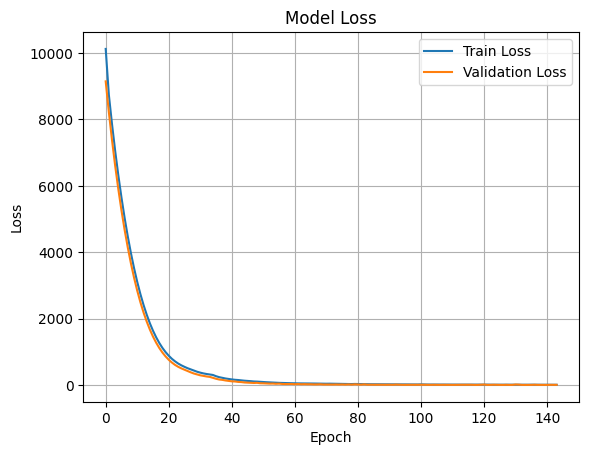

In [44]:
# Plotting training and validation error during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

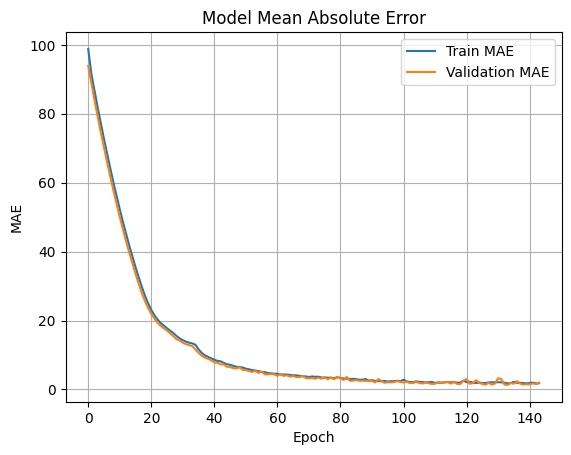

In [45]:
# Plotting training and validation MAE during training
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [46]:
# Save model
gru_model.save(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\GRU/gru_model.h5')
print('Model Saved!')
 
# load model
gru_model1=load_model(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\GRU/gru_model.h5')
gru_model1.summary()

Model Saved!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking_1 (Masking)         (None, 126, 2)            0         
                                                                 
 gru (GRU)                   (None, 64)                13056     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### CNN Model

In [47]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking_2 (Masking)         (None, 126, 2)            0         
                                                                 
 conv1d (Conv1D)             (None, 126, 64)           448       
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time = time.time()
# Train the model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
end_time = time.time()
print(f"\nTotal training time for CNN model = {end_time-start_time} seconds")

Epoch 1/2000
79/79 [==============================] - 1s 6ms/step - loss: 8976.1016 - mae: 60.2499 - val_loss: 178.9807 - val_mae: 10.6195
Epoch 2/2000
79/79 [==============================] - 0s 4ms/step - loss: 144.7279 - mae: 9.8434 - val_loss: 118.7026 - val_mae: 8.9392
Epoch 3/2000
79/79 [==============================] - 0s 4ms/step - loss: 102.1310 - mae: 8.3661 - val_loss: 85.9000 - val_mae: 7.5683
Epoch 4/2000
79/79 [==============================] - 0s 4ms/step - loss: 71.6171 - mae: 6.9759 - val_loss: 58.9979 - val_mae: 6.2037
Epoch 5/2000
79/79 [==============================] - 0s 4ms/step - loss: 50.0599 - mae: 5.8055 - val_loss: 43.1180 - val_mae: 5.2489
Epoch 6/2000
79/79 [==============================] - 0s 4ms/step - loss: 38.3196 - mae: 5.0424 - val_loss: 35.5778 - val_mae: 4.7488
Epoch 7/2000
79/79 [==============================] - 0s 4ms/step - loss: 32.6055 - mae: 4.6158 - val_loss: 32.1864 - val_mae: 4.5098
Epoch 8/2000
79/79 [==============================] - 

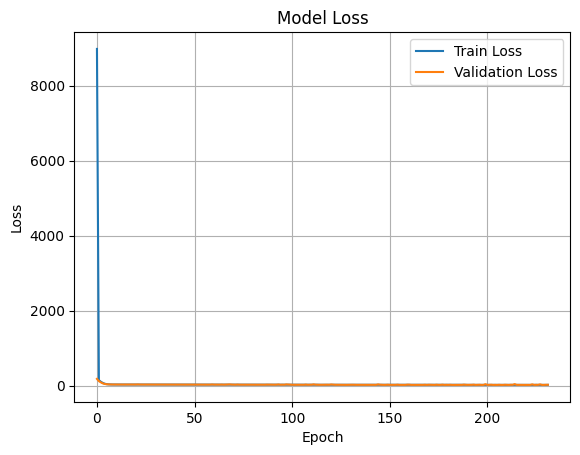

In [49]:
# Plotting training and validation error during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

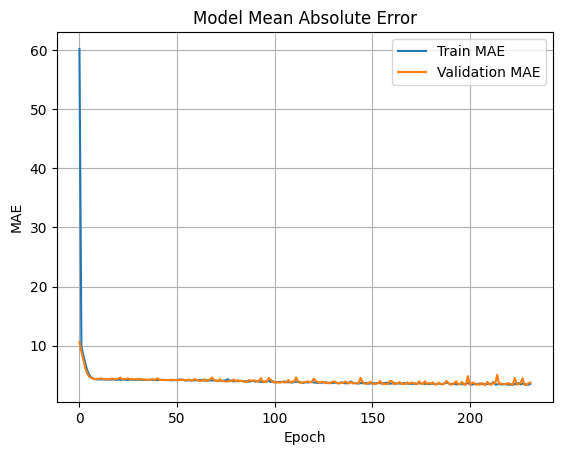

In [50]:
# Plotting training and validation MAE during training
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [51]:
# Save model
cnn_model.save(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\CNN/cnn_model.h5')
print('Model Saved!')
 
# load model
cnn_model=load_model(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\CNN/cnn_model.h5')
cnn_model.summary()

Model Saved!
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking_2 (Masking)         (None, 126, 2)            0         
                                                                 
 conv1d (Conv1D)             (None, 126, 64)           448       
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________

#### TCN Model

In [52]:
# Compile the model
tcn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
tcn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking_3 (Masking)         (None, 126, 2)            0         
                                                                 
 tcn (TCN)                   (None, 64)                111808    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111873 (437.00 KB)
Trainable params: 111873 (437.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time = time.time()
# Train the model
history = tcn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()
print(f"\nTotal training time for TCN model = {end_time-start_time} seconds")

Epoch 1/2000
20/20 [==============================] - 9s 324ms/step - loss: 480423.7500 - mae: 463.0327 - val_loss: 34405.1641 - val_mae: 175.6150
Epoch 2/2000
20/20 [==============================] - 6s 311ms/step - loss: 8262.7207 - mae: 69.2684 - val_loss: 1873.0127 - val_mae: 34.3643
Epoch 3/2000
20/20 [==============================] - 6s 292ms/step - loss: 1261.5155 - mae: 26.3590 - val_loss: 547.0551 - val_mae: 17.6286
Epoch 4/2000
20/20 [==============================] - 6s 309ms/step - loss: 460.8004 - mae: 15.4377 - val_loss: 277.1165 - val_mae: 12.2442
Epoch 5/2000
20/20 [==============================] - 6s 305ms/step - loss: 262.8290 - mae: 11.4969 - val_loss: 174.7973 - val_mae: 10.0210
Epoch 6/2000
20/20 [==============================] - 6s 308ms/step - loss: 172.0441 - mae: 9.4901 - val_loss: 128.7393 - val_mae: 8.5432
Epoch 7/2000
20/20 [==============================] - 6s 294ms/step - loss: 129.6883 - mae: 8.3167 - val_loss: 103.8931 - val_mae: 7.6269
Epoch 8/2000
2

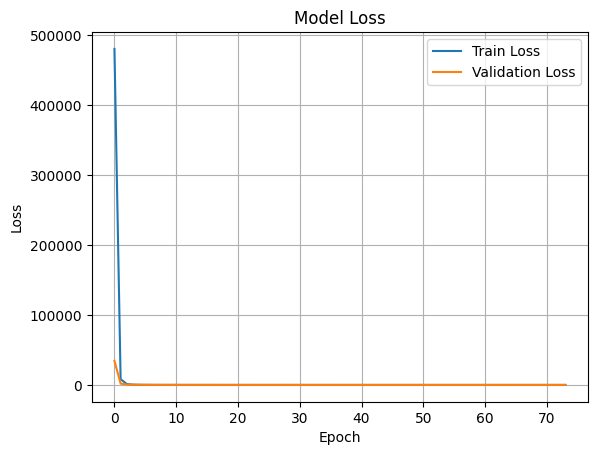

In [54]:
# Plotting training and validation error during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

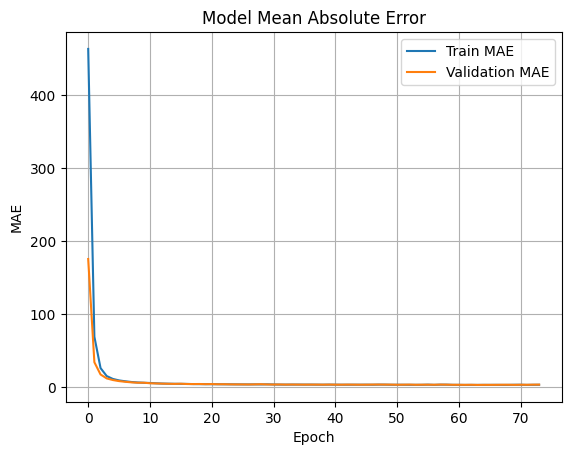

In [55]:
# Plotting training and validation MAE during training
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [56]:
# Save model
tcn_model.save(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\TCN/tcn_model.h5')
print('Model Saved!')
 
# load model
tcn_model=load_model(r'E:\MS in Robosys\Job applications\New Job Applications\sensXPERT\Task\models\TCN/tcn_model.h5', custom_objects={'TCN': TCN})
tcn_model.summary()

Model Saved!
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 126, 2)]          0         
                                                                 
 masking_3 (Masking)         (None, 126, 2)            0         
                                                                 
 tcn (TCN)                   (None, 64)                111808    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111873 (437.00 KB)
Trainable params: 111873 (437.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluating models

#### LSTM Model

In [57]:
test_loss, test_mae = lstm_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

25/25 - 1s - loss: 4.4042 - mae: 1.3572 - 1s/epoch - 56ms/step
Test Loss: 4.404233932495117
Test MAE: 1.3572161197662354


#### GRU Model

In [58]:
test_loss, test_mae = gru_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

25/25 - 0s - loss: 6.7036 - mae: 1.3926 - 297ms/epoch - 12ms/step
Test Loss: 6.703583240509033
Test MAE: 1.392633080482483


#### CNN Model

In [59]:
test_loss, test_mae = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

25/25 - 0s - loss: 16.0639 - mae: 3.1570 - 125ms/epoch - 5ms/step
Test Loss: 16.063894271850586
Test MAE: 3.1569812297821045


#### TCN Model

In [60]:
test_loss, test_mae = tcn_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

25/25 - 1s - loss: 17.6042 - mae: 3.2209 - 797ms/epoch - 32ms/step
Test Loss: 17.604162216186523
Test MAE: 3.2208988666534424


## Comparing predictions and targets

##### Comparison between predicted by actual delta_T values can be shown effectively by plotting them for different test cycles/ measurements.

##### Hence, plotting actual and predicted delta_T values for first 25 test cycles/ measurements

##### LSTM Model

In [61]:
predictions = lstm_model.predict(X_test)

25/25 [==============================] - 1s 14ms/step


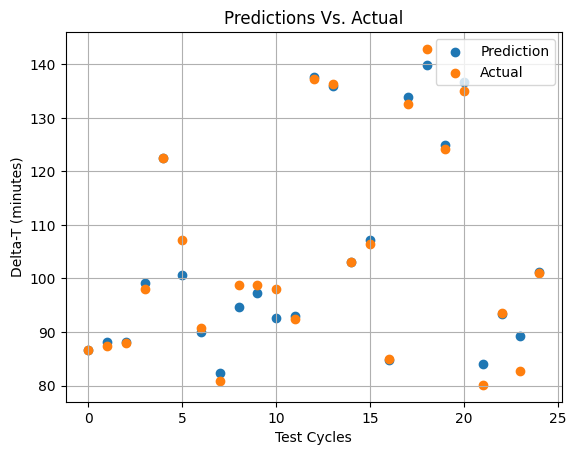

In [62]:
plt.scatter(range(25), predictions[:25], label='Prediction')
plt.scatter(range(25), y_test[:25], label='Actual')
plt.title('Predictions Vs. Actual')
plt.ylabel('Delta-T (minutes)')
plt.xlabel('Test Cycles')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### GRU Model

In [63]:
predictions = gru_model.predict(X_test)

25/25 [==============================] - 1s 11ms/step


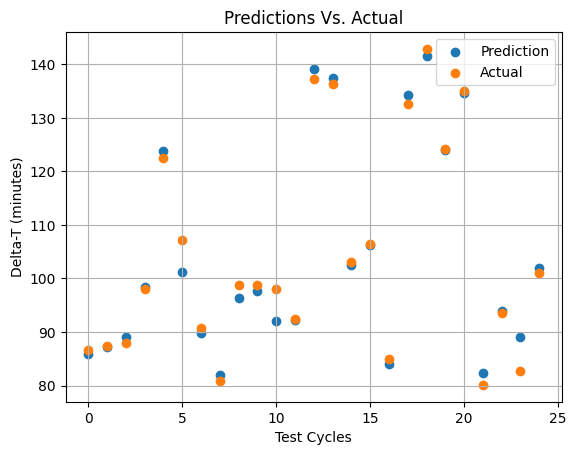

In [64]:
plt.scatter(range(25), predictions[:25], label='Prediction')
plt.scatter(range(25), y_test[:25], label='Actual')
plt.title('Predictions Vs. Actual')
plt.ylabel('Delta-T (minutes)')
plt.xlabel('Test Cycles')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

##### CNN Model

In [65]:
predictions = cnn_model.predict(X_test)

25/25 [==============================] - 0s 1ms/step


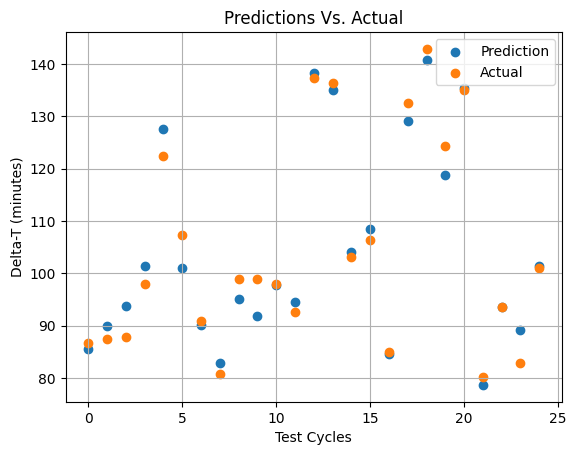

In [66]:
plt.scatter(range(25), predictions[:25], label='Prediction')
plt.scatter(range(25), y_test[:25], label='Actual')
plt.title('Predictions Vs. Actual')
plt.ylabel('Delta-T (minutes)')
plt.xlabel('Test Cycles')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

##### TCN Model

In [67]:
predictions = tcn_model.predict(X_test)

25/25 [==============================] - 1s 21ms/step


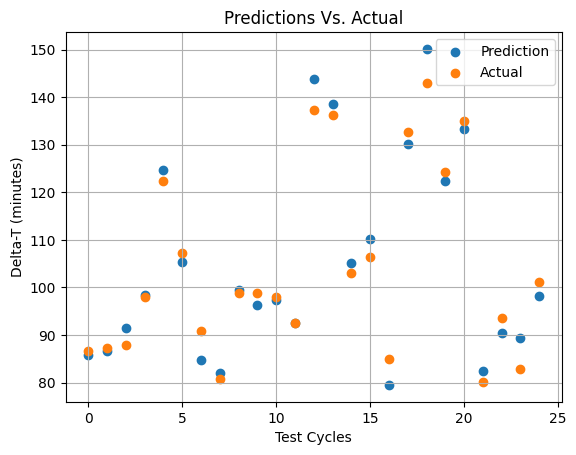

In [68]:
plt.scatter(range(25), predictions[:25], label='Prediction')
plt.scatter(range(25), y_test[:25], label='Actual')
plt.title('Predictions Vs. Actual')
plt.ylabel('Delta-T (minutes)')
plt.xlabel('Test Cycles')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## LSTM and GRU based models performed the best